In [1]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "aeroscapes"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "project5.", data_nomi = "aeroscapes")

Dataset yuklab olingan. project5./aeroscapes papkasini ni tekshiring.


In [2]:
import albumentations as A
def get_albumentations(size):
    return [A.Compose([A.Resize(size, size),
                      A.HorizontalFlip(0.5),
                      A.VerticalFlip(0.5),
                      A.GaussNoise(0.2)]),
                     A.Compose([A.Resize(size, size)])
                     ]
tr_ts, ts_ts = get_albumentations(320)
tr_ts, ts_ts

(Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
   HorizontalFlip(always_apply=0.5, p=0.5),
   VerticalFlip(always_apply=0.5, p=0.5),
   GaussNoise(always_apply=False, p=0.5, var_limit=(0, 0.2), per_channel=True, mean=0),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True),
 Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True))

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from torchvision import transforms as T
import cv2, torch, numpy as np
from PIL import Image


class CustomDataset(Dataset):
    
    def __init__(self, root, im_files = [".png", ".jpg", ".jpeg"], transformations = None):
        super().__init__()
        
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        
        self.im_paths = sorted(glob(f"{root}/images/*[{im_file for im_file in im_files}]")) 
        print(len(self.im_paths))
        self.gt_paths = glob(f"{root}/labels/*[{im_file for im_file in im_files}]") 
        print(len(self.gt_paths))
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im = cv2.cvtColor(cv2.imread(self.im_paths[idx]), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(self.gt_paths[idx]), cv2.COLOR_BGR2GRAY)
        
        if self.transformations is not None:
            transformed = self.transformations(image = im, mask = gt)
            im = transformed["image"]
            gt = transformed["mask"]
        
        im = self.tensorize(im)
        gt = torch.tensor(gt > 5).long()
            
        return im, gt

root = "../Downloads/project5/aeroscapes/aerospaces"
mod = CustomDataset(root = root, transformations = ts_ts)
mod[0][0].shape

3269
3269


torch.Size([3, 320, 320])

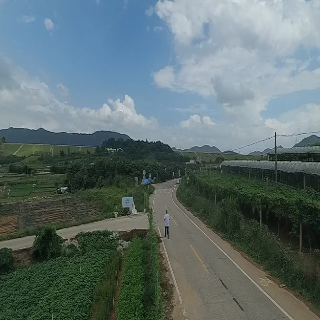

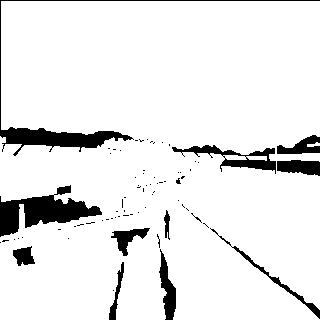

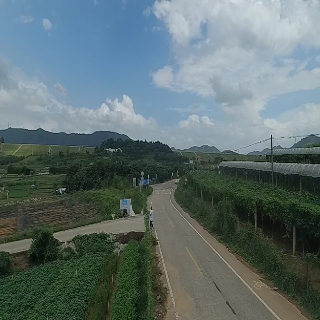

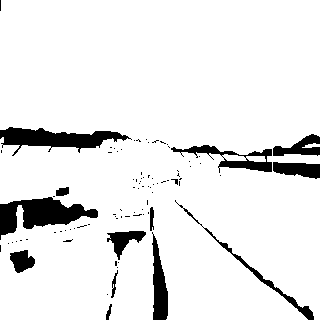

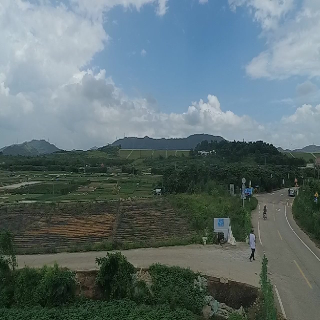

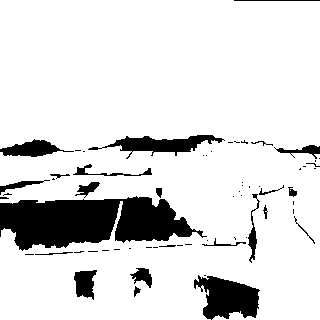

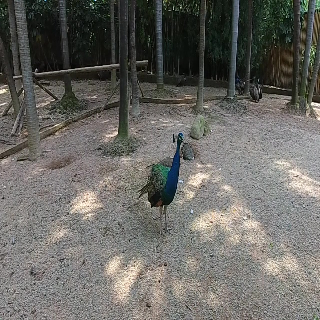

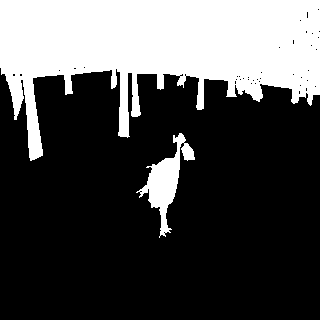

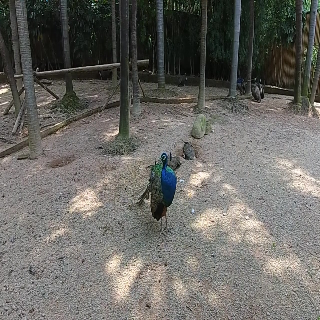

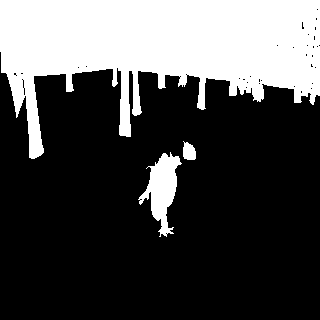

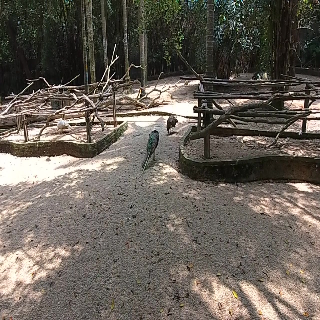

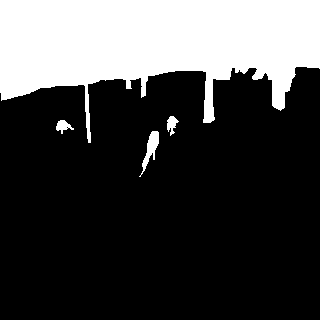

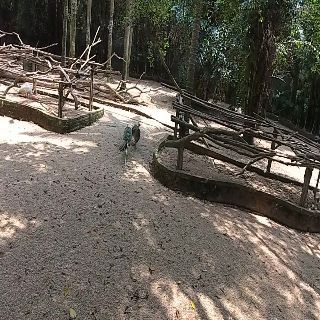

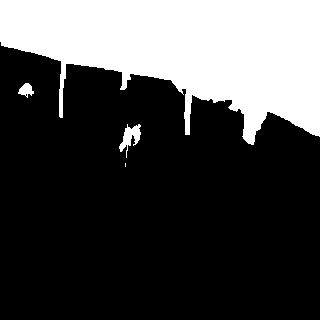

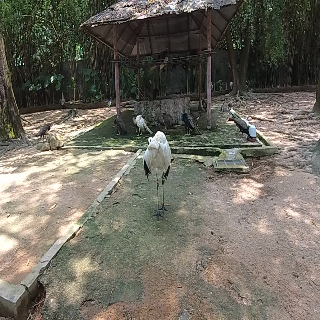

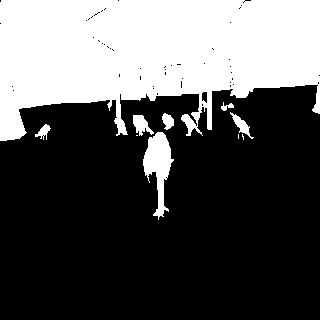

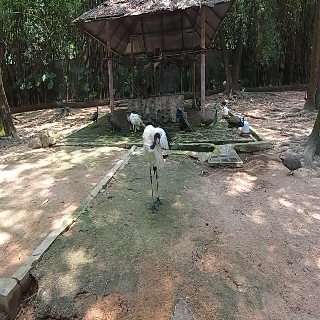

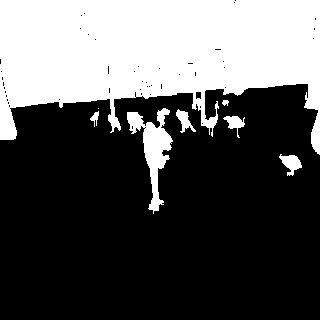

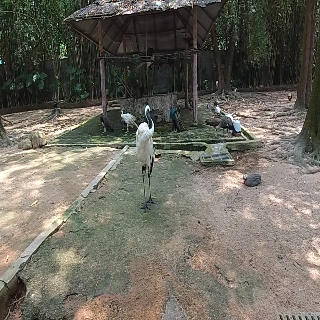

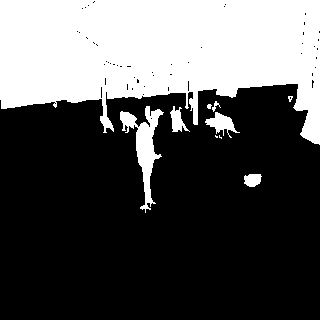

In [4]:
def ten_2_np(rasm):
    return (rasm * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8) if len(rasm) == 3 else (rasm * 255).detach().cpu().numpy().astype(np.uint8)

for idx, data in enumerate(mod):
    if idx == 10: break
    im, gt = data
    display(Image.fromarray(ten_2_np(im)))
    display(Image.fromarray(ten_2_np(gt)))

In [5]:
def dataloaders(root, transformations, bs, split =[0.9, 0.05, 0.05]):
    #ds = CustomDataset(root = root, transformations=transformations)
    ds_len = len(mod)
  
    tr_len =int(split[0]*ds_len)
    val_len =int(split[1]*ds_len)
    ts_len = ds_len-(tr_len+val_len)
    
    tr_ds, val_ds, ts_ds = random_split(mod,[tr_len, val_len, ts_len])
    
    
    print(len(tr_ds))
    print(len(val_ds))
    print(len(ts_ds))
    
    tr_dl = DataLoader(tr_ds, batch_size =bs, shuffle =True, num_workers =0)
    val_dl = DataLoader(val_ds, batch_size =bs, shuffle =True, num_workers =0)
    ts_dl = DataLoader(ts_ds, batch_size =1, shuffle =False, num_workers =0)
    return tr_dl, val_dl, ts_dl

    
tr_dl, val_dl, ts_dl = dataloaders(root = root, transformations= ts_ts, bs = 8 ) 

2942
163
164


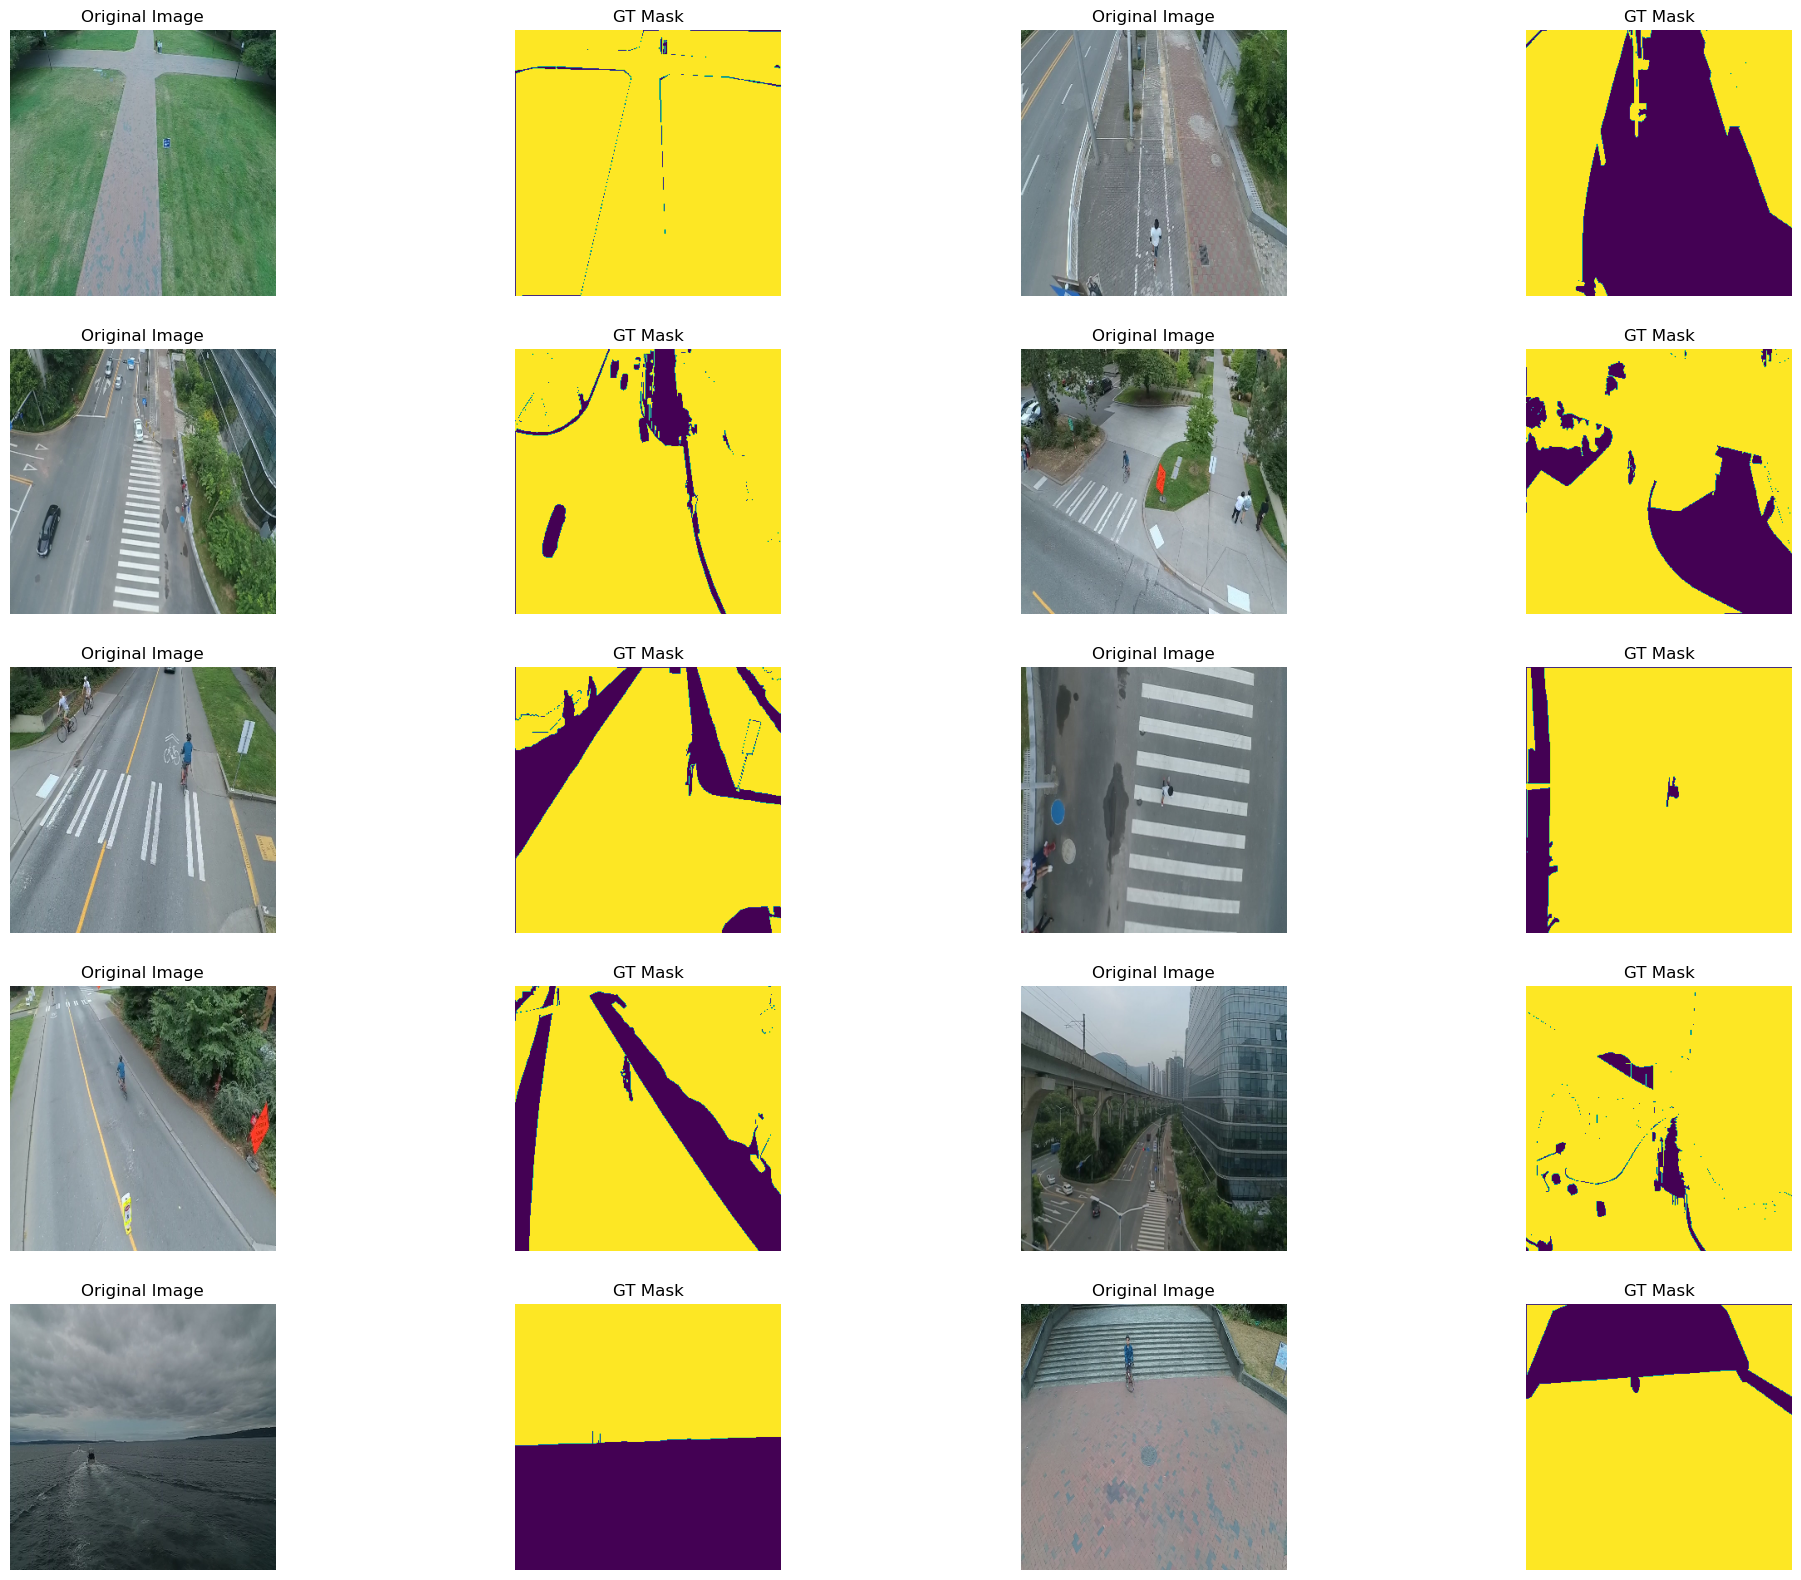

In [18]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8"))
    plt.axis("off"); plt.title(title)     
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indexs = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indexs):
        
        if count == n_ims + 1: break
        
        im, gt = ds[index]
    
        count = plot(rows, cols, count, im = im)
        
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "GT Mask")
        
visualize(tr_dl.dataset, n_ims = 20)

In [6]:
import segmentation_models_pytorch as smp
model = smp.Unet(encoder_name = "mobilenet_v2", classes = 2, encoder_depth = 5, encoder_weights = "imagenet", activation = None, decoder_channels = [256, 128, 64, 32, 16])
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [7]:
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
loss_fc = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params = model.parameters(), lr = 1e-3)

In [19]:
class Metrics():
    def __init__(self, pred, gt, loss_fn, eps =3e-4, number_class =2):
        
        self.pred = torch.argmax(torch.nn.functional.softmax(pred, dim =1), dim =1)
    
        self.pred_ =pred
        self.gt =gt
        self.loss_fn =loss_fn
        self.eps =eps
        self.number_class =number_class

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum())/float(match.sum())
        
    def mioU(self):
        pred, gt =self.to_contiguous(self.pred), self.to_contiguous(self.gt) 
        Iou_class = []
        for a in range(self.number_class):
            match_pred = pred ==a
            match_gt =gt==a
            if match_gt.long().sum().item()==0: IoU_number_class.append(np.nan)
            else:
                intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                union = torch.logical_or(match_pred, match_gt).sum().float().item()

                iou = (intersection)/(union+self.eps)
                Iou_class.append(iou)

            return np.nanmean(Iou_class)
    
    def loss(self):
        
        return self.loss_fn(self.pred_, self.gt)

In [21]:
def train(model, tr_dlr, val_dlr, epochs, device, loss_fn, opt, save_prefix):
    
    tr_loss, tr_pa, tr_iou =[],[],[]
    val_loss, val_pa, val_iou =[],[],[]
    tr_len, val_len = len(tr_dlr), len(val_dlr)
    
    
    best_loss = np.inf
    os.makedirs("save_aerospaces_best_model", exist_ok=True)
    model.to(device)
        
    print("Train is starting ....")
    for epoch in range(epochs):
        tr_losses, tr_pas, tr_ious =0,0,0
        model.train()
        print(f"{epoch+1} - epoch is starting")
        for idx, batch in enumerate(tqdm(tr_dlr)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            met = Metrics(pred, gt, loss_fn)
            
            losses =met.loss()
            
            tr_ious+=met.mioU()
            tr_pas +=met.PA()
            tr_losses+ losses.item()
            
            opt.zero_grad()
            losses.backward()
            opt.step()
        print(f"{epoch+1} - epoch validation starting....")
        model.eval()
        val_losses, val_pas, val_ious =0,0,0
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dlr)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)
                
                met = Metrics(pred, gt, loss_fn)
                
                val_losses+=met.loss().item()
                val_pas +=met.PA()
                val_ious+=met.mioU()
                
        print(f"{epoch+1} - epoch train finished")
        
        tr_ious /=tr_len
        tr_pas /= tr_len
        tr_losses/= tr_len
        
        val_ious /=val_len
        val_pas /= val_len
        val_losses /= val_len
        print("\n ------------------------------------------")
        print(f"{epoch+1} - epoch train result: \n")
        print(f"Train loss                 --> {tr_losses:.3f}")
        print(f"Train PA                   --> {tr_pas:.3f}")
        print(f"Train mIoU                 --> {tr_ious:.3f}\n")
        print(f"{epoch+1} - epoch validayion result: \n")
        print(f"Validation loss             --> {val_losses:.3f}")
        print(f"Validation PA               --> {val_pas:.3f}")
        print(f"Validation mIoU             --> {val_ious:.3f}")
        
        
        tr_loss.append(tr_losses)
        tr_pa.append(tr_pas)
        tr_iou.append(tr_ious)
        val_loss.append(val_losses)
        val_pa.append(val_pas)
        val_iou.append(val_ious)
        
        if val_losses < best_loss:

            best_loss = val_losses
            
            print(f"The model with the lowest error is saved")
            torch.save(model, f"save_aerospaces_best_model/{save_prefix}_best_model.pt")
                    
    return {"tr_loss": tr_loss,"tr_pa": tr_pa, "tr_iou": tr_iou,
               "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou}
        
    
result =train(model = model, tr_dlr = tr_dl, val_dlr = val_dl, epochs = 10,
              device = device, loss_fn = loss_fc, opt = optimazer, save_prefix = "aerospaces")  

Train is starting ....
1 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:54<00:00,  6.80it/s]


1 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.51it/s]


1 - epoch train finished

 ------------------------------------------
1 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.681

1 - epoch validayion result: 

Validation loss             --> 0.138
Validation PA               --> 1.000
Validation mIoU             --> 0.725
The model with the lowest error is saved
2 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:54<00:00,  6.80it/s]


2 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.43it/s]


2 - epoch train finished

 ------------------------------------------
2 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.724

2 - epoch validayion result: 

Validation loss             --> 0.139
Validation PA               --> 1.000
Validation mIoU             --> 0.748
3 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:54<00:00,  6.81it/s]


3 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.42it/s]


3 - epoch train finished

 ------------------------------------------
3 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.739

3 - epoch validayion result: 

Validation loss             --> 0.114
Validation PA               --> 1.000
Validation mIoU             --> 0.774
The model with the lowest error is saved
4 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:55<00:00,  6.68it/s]


4 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.28it/s]


4 - epoch train finished

 ------------------------------------------
4 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.780

4 - epoch validayion result: 

Validation loss             --> 0.107
Validation PA               --> 1.000
Validation mIoU             --> 0.780
The model with the lowest error is saved
5 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:55<00:00,  6.65it/s]


5 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.26it/s]


5 - epoch train finished

 ------------------------------------------
5 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.785

5 - epoch validayion result: 

Validation loss             --> 0.113
Validation PA               --> 1.000
Validation mIoU             --> 0.770
6 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:56<00:00,  6.55it/s]


6 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.26it/s]


6 - epoch train finished

 ------------------------------------------
6 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.808

6 - epoch validayion result: 

Validation loss             --> 0.105
Validation PA               --> 1.000
Validation mIoU             --> 0.805
The model with the lowest error is saved
7 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:56<00:00,  6.57it/s]


7 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.28it/s]


7 - epoch train finished

 ------------------------------------------
7 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.795

7 - epoch validayion result: 

Validation loss             --> 0.122
Validation PA               --> 1.000
Validation mIoU             --> 0.796
8 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:55<00:00,  6.60it/s]


8 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.18it/s]


8 - epoch train finished

 ------------------------------------------
8 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.814

8 - epoch validayion result: 

Validation loss             --> 0.090
Validation PA               --> 1.000
Validation mIoU             --> 0.823
The model with the lowest error is saved
9 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:56<00:00,  6.53it/s]


9 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.15it/s]


9 - epoch train finished

 ------------------------------------------
9 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.829

9 - epoch validayion result: 

Validation loss             --> 0.088
Validation PA               --> 1.000
Validation mIoU             --> 0.825
The model with the lowest error is saved
10 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:56<00:00,  6.56it/s]


10 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.16it/s]

10 - epoch train finished

 ------------------------------------------
10 - epoch train result: 

Train loss                 --> 0.000
Train PA                   --> 1.000
Train mIoU                 --> 0.836

10 - epoch validayion result: 

Validation loss             --> 0.090
Validation PA               --> 1.000
Validation mIoU             --> 0.821


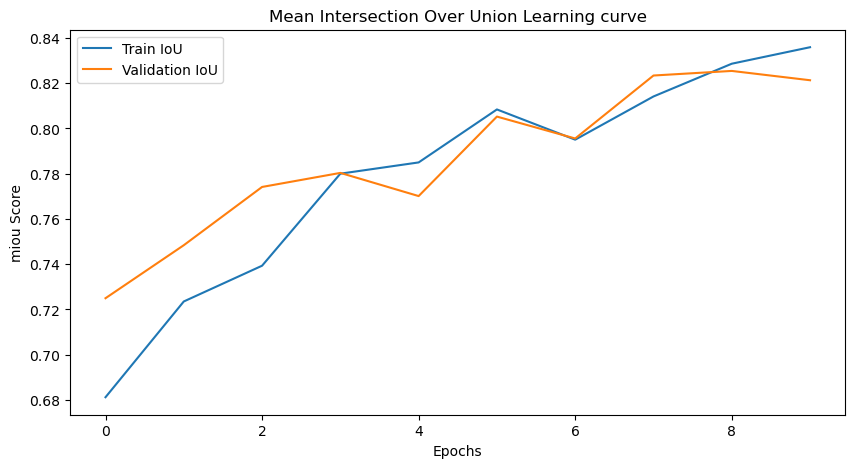

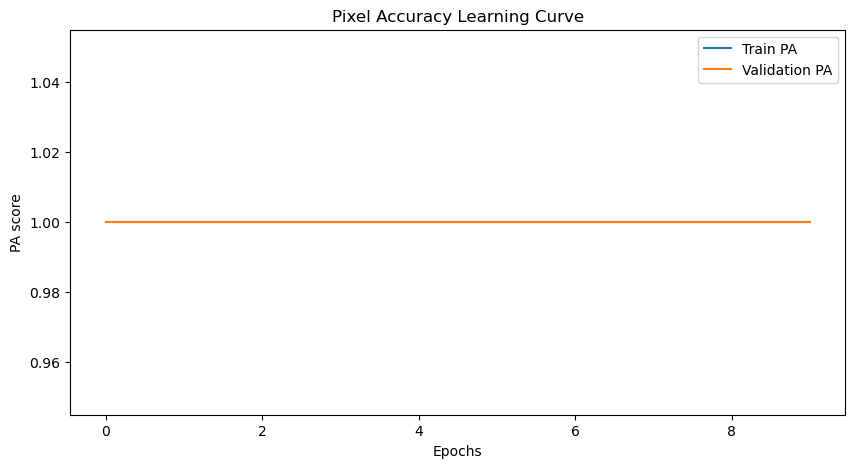

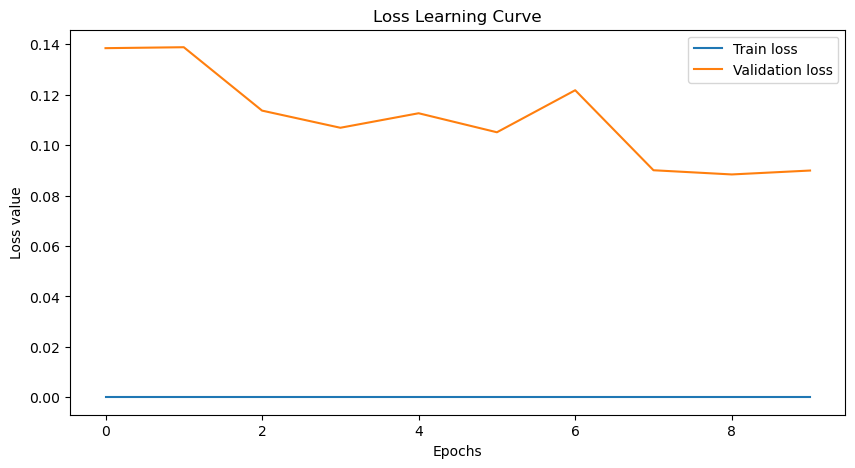

In [33]:
class visualize():
    def __init__(self, res):
    
        plt.figure(figsize=(10,5))
        plt.title("Mean Intersection Over Union Learning curve")
        plt.plot(res["tr_iou"], label = "Train IoU")
        plt.plot(res["val_iou"], label = "Validation IoU")
        plt.xlabel("Epochs")
        plt.ylabel("miou Score")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.title("Pixel Accuracy Learning Curve")
        plt.plot(res["tr_pa"], label = "Train PA")
        plt.plot(res["val_pa"], label = "Validation PA")
        plt.xlabel("Epochs")
        plt.ylabel("PA score")
        plt.legend()
        plt.show
        
        plt.figure(figsize=(10,5))
        plt.title("Loss Learning Curve")
        plt.plot(res["tr_loss"], label = "Train loss")
        plt.plot(res["val_loss"], label = "Validation loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss value")
        plt.legend()
        plt.show
        
        
    
visualize(result)    
    

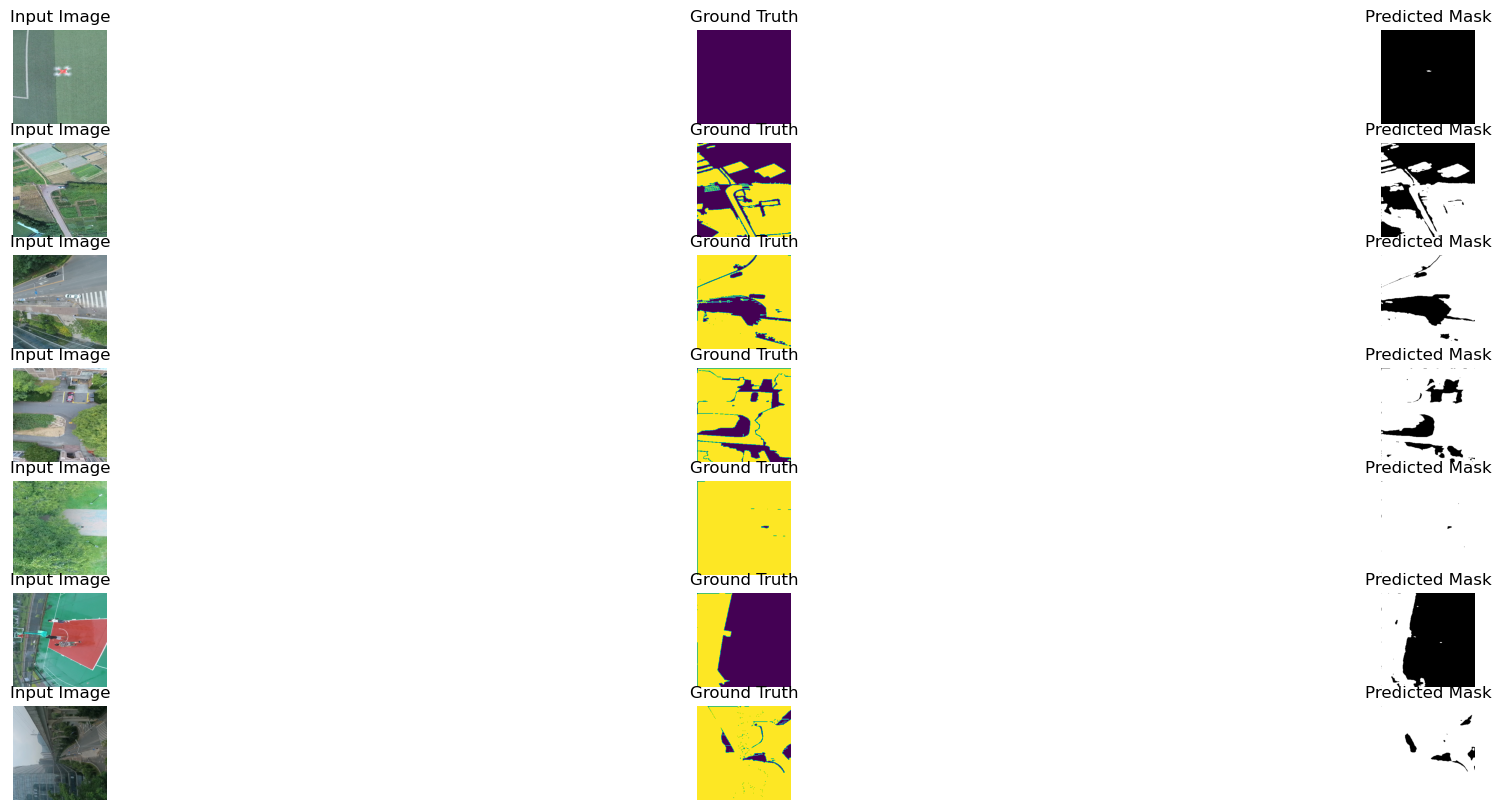

In [53]:
def inference(ds, model, device, n_ims=20):
    cols = 3
    rows = (n_ims + cols - 1) // cols  
    count = 1
    
    images, gts, preds = [], [], []
    for idx, data in enumerate(ds):
        im, gt = data
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
        images.append(im.cpu().numpy()) #.cpu()
        gts.append(gt.cpu().numpy())
        preds.append(pred.cpu().numpy())

    plt.figure(figsize=(25, 10))
    while count <= n_ims: 
        for idx, (im, gt, pred) in enumerate(zip(images, gts, preds)):
           
            if count > n_ims:
                break
            plt.subplot(rows, cols, count)
            
            plt.imshow(im.squeeze(0).transpose(2, 1, 0))
            plt.title("Input Image")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(gt.transpose(2, 1, 0))
        
            plt.title("Ground Truth")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(pred.transpose(2, 1, 0), cmap = 'gray')
            plt.title("Predicted Mask")
            plt.axis('off')
            count += 1

    plt.show()

model = torch.load("save_aerospaces_best_model/aerospaces_best_model.pt")
inference(ts_dl, model=model, device=device)